In [1]:
from pathlib import Path
import yaml

import shapely
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from ard.utils.io import load_yaml
from ard.api import set_up_ard_model
from ard.viz.layout import plot_layout

plt.style.use(
    [
        # "dark_background",
        "https://raw.githubusercontent.com/cfrontin/tools_cvf/main/tools_cvf/stylesheet_cvf.mplstyle",
        "https://raw.githubusercontent.com/cfrontin/tools_cvf/main/tools_cvf/stylesheet_nrel.mplstyle",
    ]
)

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

In [2]:
# generate the ard shape with shapely

# the A
center_a = (0.5, 0.5)
outer_radius_a = 0.5
inner_radius_a = 0.25

torus_a = (
    Point(center_a)
    .buffer(outer_radius_a, resolution=100)
    .difference(Point(center_a).buffer(inner_radius_a, resolution=100))
)
rectangle_a = Polygon(
    [(0.75, 0.0), (1.0, 0.0), (1.0, 1.0), (0.75, 1.0)],
)
shape_a = torus_a.union(rectangle_a)

# the R
# center_r = (center_a[0]+0.75, center_a[1])
center_r = (center_a[0] + 0.9375, center_a[1])
outer_radius_r = 0.5
inner_radius_r = 0.25
torus_r = (
    Point(center_r)
    .buffer(outer_radius_r, resolution=100)
    .difference(Point(center_r).buffer(inner_radius_r, resolution=100))
)
shape_r = torus_r.difference(
    Polygon(
        [
            (center_r[0] - outer_radius_r, center_r[1]),
            (center_r[0] + outer_radius_r, center_r[1]),
            (center_r[0] + outer_radius_r, center_r[1] - outer_radius_r),
            (center_r[0] - outer_radius_r, center_r[1] - outer_radius_r),
        ]
    )
).union(
    Polygon(
        [
            (center_r[0] - outer_radius_r, center_r[1] + outer_radius_r),
            (center_r[0] - inner_radius_r, center_r[1] + outer_radius_r),
            (center_r[0] - inner_radius_r, center_r[1] - outer_radius_r),
            (center_r[0] - outer_radius_r, center_r[1] - outer_radius_r),
        ]
    )
)

# the D
# center_d = (center_r[0]+0.75, center_r[1])
center_d = (center_r[0] + 0.9375, center_r[1])
outer_radius_d = 0.5
inner_radius_d = 0.25
torus_d = (
    Point(center_d)
    .buffer(outer_radius_d, resolution=100)
    .difference(Point(center_d).buffer(inner_radius_d, resolution=100))
)
shape_d = torus_d.union(
    Polygon(
        [
            (
                center_d[0] + outer_radius_d,
                center_d[1] + outer_radius_d + inner_radius_d,
            ),
            (
                center_d[0] + inner_radius_d,
                center_d[1] + outer_radius_d + inner_radius_d,
            ),
            (center_d[0] + inner_radius_d, center_d[1] - outer_radius_d),
            (center_d[0] + outer_radius_d, center_d[1] - outer_radius_d),
        ]
    )
)

# the ARD
shape_ard = shape_a.union(shape_r).union(shape_d)

The 'resolution' argument is deprecated. Use 'quad_segs' instead

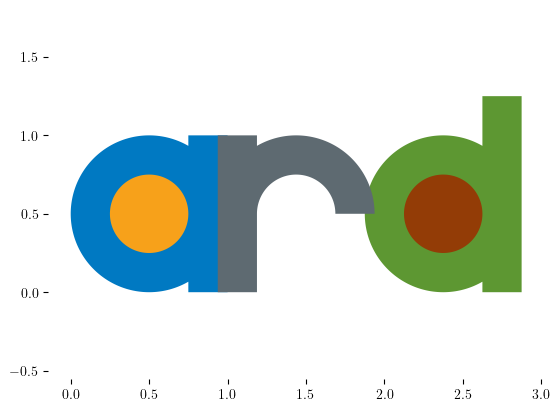

In [3]:
if True:  # set true to do a rudimentary logo plot
    # plot A
    plt.fill(shape_a.exterior.xy[0], shape_a.exterior.xy[1])
    for interior in shape_a.interiors:
        plt.fill(interior.xy[0], interior.xy[1])
    # plot D
    plt.fill(shape_d.exterior.xy[0], shape_d.exterior.xy[1])
    for interior in shape_d.interiors:
        plt.fill(interior.xy[0], interior.xy[1])
    # plot R
    plt.fill(shape_r.exterior.xy[0], shape_r.exterior.xy[1])
    for interior in shape_r.interiors:
        plt.fill(interior.xy[0], interior.xy[1])

    plt.axis("equal");

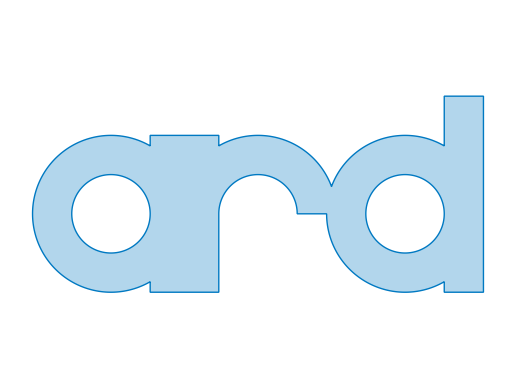

In [4]:
# generate a nice ard logo in blue
import shapely.plotting

fig, ax = plt.subplots()
shapely.plotting.plot_polygon(shape_ard, add_points=False, ax=ax)
ax.axis("equal")
ax.set_axis_off()
plt.savefig(
    "logo.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

In [5]:
# generate points for a simulation on the logo
polygons = [
    (1.0e3 * np.array(shape_ard.exterior.xy).T).tolist(),
    *[(1.0e3 * np.array(interior.xy).T).tolist() for interior in shape_ard.interiors],
]

In [6]:
with open("logo_polygons.yaml", "w") as fout:
    yaml.safe_dump(polygons, fout)

In [7]:
# for polygon in polygons:
#     print("- x:")
#     for val in np.array(polygon)[:,0]:
#         print(f"    - {val}")
#     print("- y:")
#     for val in np.array(polygon)[:,1]:
#         print(f"    - {val}")

In [8]:
# load input
input_dict = load_yaml("./inputs/ard_system.yaml")

ardprob = set_up_ard_model(input_dict=input_dict)

Adding top_level
Adding aepFLORIS
Adding collection
Adding spacing_constraint
Adding boundary


floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.


In [ ]:
ardprob.model.set_input_defaults(
    "x_turbines",
    val=input_dict["modeling_options"]["windIO_plant"]["wind_farm"]["layouts"][
        "coordinates"
    ]["x"],
    units="km",
)
ardprob.model.set_input_defaults(
    "y_turbines",
    val=input_dict["modeling_options"]["windIO_plant"]["wind_farm"]["layouts"][
        "coordinates"
    ]["y"],
    units="km",
)
ardprob.run_driver()

/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/core/group.py:368: PromotionWarning:<model> <class Group>: Setting input defaults for input 'x_turbines' which override previously set defaults for ['auto', 'prom', 'units'].
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/core/group.py:368: PromotionWarning:<model> <class Group>: Setting input defaults for input 'y_turbines' which override previously set defaults for ['auto', 'prom', 'units'].
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/recorders/sqlite_recorder.py:231: UserWarning:The existing case recorder file, /Users/cfrontin/codes/Ard/assets/logomaker/problem_out/opt_results.sql, is being overwritten.
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/core/driver.py:700: DriverWarning:The following design variable initial conditions are out of their specified bounds:
  x_turbines
    val: [-2500000

In [ ]:
plot_layout(ardprob, input_dict=input_dict, include_cable_routing=True)